In [1]:
import pandas as pd
import numpy as np

import gensim as gn
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import sklearn 
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import random

#maybe used for plotting later 
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# stop words and lda stuff 
import re
import logging
import matplotlib.pyplot as plt 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words = stop_words + ['com', 'edu', 'subject', 'lines', 'organization', 'would', 'article', 'could',
                           'The','This','use','As','While','We','These','A','et.']
#more stop words
gist_file = open("stop.txt", "r")
content = gist_file.read()
stopwords_online = content.split(",")
gist_file.close()
import spacy
nlp = spacy.load('en_core_web_sm') 



In [2]:
data= pd.read_csv("inclusion_data_finalabstractcut (1).csv")

data=data.iloc[:,1:]
data

,abstract
0,The Benefits of Enlightenment: A Strategic Pe...
1,Beyond instructional practices: Characterizin...
2,Educating Students in Technology Enhanced Lea...
3,"Can a Brief, Digital Skill Training Intervent..."
4,"Course Design, Quality Matters Training, and ..."
...,...
690,Using Team-Based Learning in Discussion and W...
691,The Business of Translation: The Johns Hopkin...
692,Creating a Transformative Learning Experience...
693,The Educational Value of the College Fed Chal...


In [79]:
data_processed=[]
stop_words = stop_words + stopwords_online + ['student', 'teaching','learning','education','study',
                                             'learn','university','college','undergraduate']
for num,doc in enumerate(data['abstract']):
    doc_out = []
    n_doc = nlp(doc) 

    ###
    for wd in n_doc:
        if wd.is_alpha == False:
            continue 
       
        lemmatized_word = wd.lemma_ 
        if lemmatized_word not in stop_words:  # remove stopwords 

            doc_out = doc_out + [lemmatized_word.lower()] 
        else:
             continue
    data_processed.append(doc_out)

In [ ]:
data_processed[0]

# Testing on results by running 36 models with 695 data sets via gridsearch

In [90]:
#needs to be a list of scentences for the vectorization function 
lis=[]
# random.shuffle(data_processed)
for i in data_processed:
    mystring= ' '.join(i)
    lis.append(mystring)


In [91]:
# for me 
dit = corpora.Dictionary(data_processed)
corpus = [dit.doc2bow(line) for line in data_processed]
r_corpus = [[(dit[id], count) for id, count in line] for line in corpus]


2024-05-06 11:22:30,081 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-06 11:22:30,166 : INFO : built Dictionary<8563 unique tokens: ['approach', 'assure', 'attitude', 'audience', 'barrier']...> from 695 documents (total 74350 corpus positions)
2024-05-06 11:22:30,167 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<8563 unique tokens: ['approach', 'assure', 'attitude', 'audience', 'barrier']...> from 695 documents (total 74350 corpus positions)", 'datetime': '2024-05-06T11:22:30.167595', 'gensim': '4.2.0', 'python': '3.7.3 (default, Mar 27 2019, 22:11:17) \n[GCC 7.3.0]', 'platform': 'Linux-4.15.0-175-generic-x86_64-with-debian-buster-sid', 'event': 'created'}


In [92]:
# using this as imput for the LDA model based on processed data 
vectorizer = CountVectorizer(analyzer='word',
                             #min_df=10,     # minimum reqd occurences of a word  minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             #max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(lis)
# the input that sklearn needs for lda

In [93]:
# gridsearch 
search_params = {'n_components': [3,5], 'learning_decay': [.5,.7], 
                 'max_iter': [50,100], 'learning_offset': [1,100],
#                 'doc_topic_prior':[0.01,0.1,1], 'topic_word_prior':[0.01,0.1,1],
#                 'batch_size' : [25,100,200], 'mean_change_tol': [0,0.01,0.001,0.0001],
                'max_doc_update_iter':[10,50]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Perplexity N loglikely
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized), ', Model loglikely: ',best_lda_model.score(data_vectorized))

# Viweing topics
topic_words = {}
words=10

vocab = vectorizer.get_feature_names_out()
for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:10] #want 10 words

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Best Model's Params:  {'learning_decay': 0.5, 'learning_offset': 1, 'max_doc_update_iter': 50, 'max_iter': 50, 'n_components': 3}
Model Perplexity:  2003.2298090093475 , Model loglikely:  -561719.5017192962
Topic: 0
  skill, science, base, design, engineering, development, provide, model, experience, assessment
Topic: 1
  faculty, change, stem, practice, community, program, high, support, technology, engineering
Topic: 2
  online, design, faculty, development, practice, high, technology, science, classroom, instructor



 perplexity the lower the better and for loglikely(score) the higher the better

# Creating a graph based on the results from above

In [103]:
model.cv_results_

{'mean_fit_time': array([ 2.35315318,  2.56896572,  4.61040154,  5.052281  ,  5.88311429,
         5.60845838, 11.52624955, 10.80620213,  2.39128022,  2.555439  ,
         4.65230412,  5.05376625,  5.99735503,  5.5962656 , 10.79251428,
        10.39385786,  2.36699548,  2.54362745,  4.66800785,  5.1397409 ,
         5.64428978,  5.59058375, 11.91575294, 10.58268819,  2.36579471,
         2.57290235,  4.66983008,  5.03683023,  6.0779233 ,  5.41752529,
        10.96588988, 10.13223591]),
 'std_fit_time': array([0.04810607, 0.0246561 , 0.02444233, 0.02911432, 0.18939694,
        0.23332999, 0.53146971, 0.61915146, 0.04599492, 0.02066976,
        0.08409088, 0.04003053, 0.19978653, 0.14701413, 1.60222415,
        0.5103155 , 0.06511819, 0.01440496, 0.10677572, 0.11600706,
        0.49941184, 0.06293834, 0.23372855, 0.21779109, 0.03569863,
        0.06316917, 0.07251884, 0.02115448, 0.17921557, 0.48720705,
        1.39910854, 0.64003669]),
 'mean_score_time': array([0.01651683, 0.01849895, 

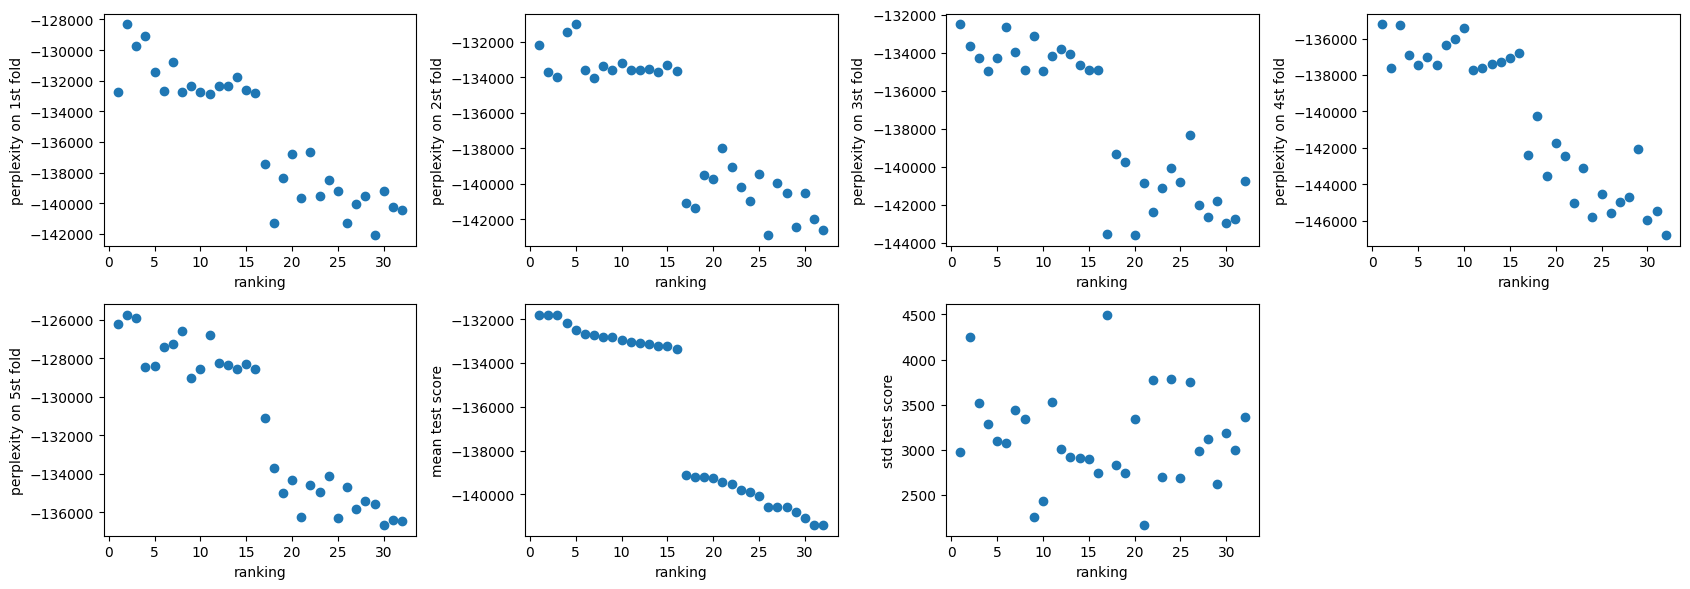

In [141]:
plt.figure(figsize=(17, 6))

plt.subplot(2,4,1,)

plt.scatter(model.cv_results_['rank_test_score'],model.cv_results_['split0_test_score'])
plt.xlabel('ranking')
plt.ylabel('perplexity on 1st fold')

plt.subplot(2,4,2)
plt.scatter(model.cv_results_['rank_test_score'],model.cv_results_['split1_test_score'])
plt.xlabel('ranking')
plt.ylabel('perplexity on 2st fold')

plt.subplot(2,4,3)
plt.scatter(model.cv_results_['rank_test_score'],model.cv_results_['split2_test_score'])
plt.xlabel('ranking')
plt.ylabel('perplexity on 3st fold')

plt.subplot(2,4,4)
plt.scatter(model.cv_results_['rank_test_score'],model.cv_results_['split3_test_score'])
plt.xlabel('ranking')
plt.ylabel('perplexity on 4st fold')

plt.subplot(2,4,5)
plt.scatter(model.cv_results_['rank_test_score'],model.cv_results_['split4_test_score'])
plt.xlabel('ranking')
plt.ylabel('perplexity on 5st fold')


plt.subplot(2,4,6)
plt.scatter(model.cv_results_['rank_test_score'],model.cv_results_['mean_test_score'])
plt.xlabel('ranking')
plt.ylabel('mean test score')

plt.subplot(2,4,7)
plt.scatter(model.cv_results_['rank_test_score'],model.cv_results_['std_test_score'])
plt.xlabel('ranking')
plt.ylabel('std test score')
plt.tight_layout()

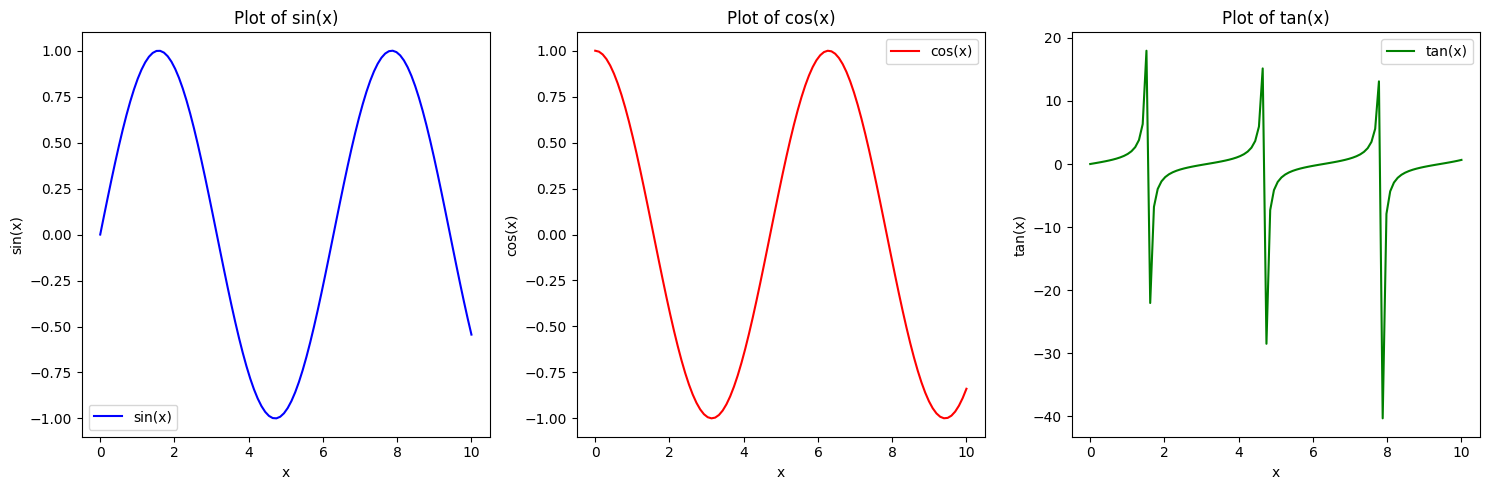

# Using grid search on random 50 outta the 695

In [ ]:
# processing the data 

data_processed=[]
stop_words = stop_words + stopwords_online + ['student', 'teaching','learning','education','study',
                                             'learn','university','college','undergraduate']
for num,doc in enumerate(data['abstract']):
    doc_out = []
    n_doc = nlp(doc) 

    ###
    for wd in n_doc:
        if wd.is_alpha == False:
            continue 
       
        lemmatized_word = wd.lemma_ 
        if lemmatized_word not in stop_words:  # remove stopwords 

            doc_out = doc_out + [lemmatized_word.lower()] 
        else:
             continue
    data_processed.append(doc_out)
    
    # radnomizing/shuffling it
    
#needs to be a list of scentences for the vectorization function 
lis=[]
random.shuffle(data_processed)
for i in data_processed[:50]:
    mystring= ' '.join(i)
    lis.append(mystring)


# using this as imput for the LDA model based on processed data 
vectorizer = CountVectorizer(analyzer='word',
                             #min_df=10,     # minimum reqd occurences of a word  minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             #max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(lis)
# the input that sklearn needs for lda


# running gridsearch and finding the best model 
search_params = {'n_components': [3,5,8], 'learning_decay': [.5,.7,1], 
                 'max_iter': [50,100], 'learning_offset': [1,10,100],
                'doc_topic_prior':[0.01,0.1,1], 'topic_word_prior':[0.01,0.1,1],
                'batch_size' : [25,100,200], 'mean_change_tol': [0,0.01,0.001,0.0001],
                'max_doc_update_iter':[10,50,100]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Perplexity N loglikely
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized), ', Model loglikely: ',best_lda_model.score(data_vectorized))

# Viweing topics
topic_words = {}
words=10

vocab = vectorizer.get_feature_names_out()
for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:10] #want 10 words

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))



# Visualse of the random 50 

# Using grid search on random 100 outta the 695

In [ ]:
# processing the data 

data_processed=[]
stop_words = stop_words + stopwords_online + ['student', 'teaching','learning','education','study',
                                             'learn','university','college','undergraduate']
for num,doc in enumerate(data['abstract']):
    doc_out = []
    n_doc = nlp(doc) 

    ###
    for wd in n_doc:
        if wd.is_alpha == False:
            continue 
       
        lemmatized_word = wd.lemma_ 
        if lemmatized_word not in stop_words:  # remove stopwords 

            doc_out = doc_out + [lemmatized_word.lower()] 
        else:
             continue
    data_processed.append(doc_out)
    
    # radnomizing/shuffling it
    
#needs to be a list of scentences for the vectorization function 
lis=[]
random.shuffle(data_processed)
for i in data_processed[:100]:
    mystring= ' '.join(i)
    lis.append(mystring)


# using this as imput for the LDA model based on processed data 
vectorizer = CountVectorizer(analyzer='word',
                             #min_df=10,     # minimum reqd occurences of a word  minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             #max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(lis)
# the input that sklearn needs for lda


# running gridsearch and finding the best model 
search_params = {'n_components': [3,5,8], 'learning_decay': [.5,.7,1], 
                 'max_iter': [50,100], 'learning_offset': [1,10,100],
                'doc_topic_prior':[0.01,0.1,1], 'topic_word_prior':[0.01,0.1,1],
                'batch_size' : [25,100,200], 'mean_change_tol': [0,0.01,0.001,0.0001],
                'max_doc_update_iter':[10,50,100]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Perplexity N loglikely
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized), ', Model loglikely: ',best_lda_model.score(data_vectorized))

# Viweing topics
topic_words = {}
words=10

vocab = vectorizer.get_feature_names_out()
for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:10] #want 10 words

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))




# using grid search to find best parameters (cant do full size because takes forever to run only with 100 rn )

In [12]:
search_params = {'n_components': [3, 5], 'learning_decay': [.5,.7,.9], 
                 'max_iter': [50,100,200,], 'learning_offset': [1,10,100]
                'doc_topic_prior':[0.01,0.1,1], 'topic_word_prior': :[0.01,0.1,1],
                'batch_size' : [25,100,200], 'mean_change_tol': [0,0.01,0.001,0.0001],
                'max_doc_update_iter':[10,100,500], }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_offset': [1, 10, 100],
                         'max_iter': [50, 100, 200], 'n_components': [3, 5]})

In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized), ', Model loglikely: ',lda_model.score(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'learning_offset': 10, 'max_iter': 200, 'n_components': 3}
Best Log Likelihood Score:  -21636.963267422438
Model Perplexity:  1586.387855248426 , Model loglikely:  -81902.48943738289


In [14]:
topic_words = {}
words=10


vocab = vectorizer.get_feature_names_out()
for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:10] #want 10 words

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  online, design, model, high, educational, development, process, skill, technology, engineering
Topic: 1
  design, base, high, assessment, project, development, practice, develop, change, technology
Topic: 2
  online, teacher, design, classroom, social, laboratory, practice, base, experience, approach


# testing with params closer to best vals 

In [16]:
search_params = {'n_components': [1,2,3], 'learning_decay': [.9,1], 
                 'max_iter': [200,500,1000], 'learning_offset': [5,10,15,20,25]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.9, 1],
                         'learning_offset': [5, 10, 15, 20, 25],
                         'max_iter': [200, 500, 1000],
                         'n_components': [1, 2, 3]})

In [17]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized), ', Model loglikely: ',lda_model.score(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'learning_offset': 10, 'max_iter': 200, 'n_components': 1}
Best Log Likelihood Score:  -18648.386238748422
Model Perplexity:  1519.118820091583 , Model loglikely:  -81902.48943738289


In [18]:
topic_words = {}
words=10


vocab = vectorizer.get_feature_names_out()
for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:10] #want 10 words

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  online, design, base, high, development, practice, technology, assessment, engineering, skill


# gridsearch with full data set 

In [ ]:
print('hi')

In [ ]:
lis=[]
for i in data_processed:
    mystring= ' '.join(i)
    lis.append(mystring)

# dit = corpora.Dictionary(data_processed)
# corpus = [dit.doc2bow(line) for line in data_processed]
# r_corpus = [[(dit[id], count) for id, count in line] for line in corpus]

vectorizer = CountVectorizer(analyzer='word',
                             #min_df=10,     # minimum reqd occurences of a word  minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             #max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(lis)
# the input that sklearn needs for lda

search_params = {'n_components': [3,5,8], 'learning_decay': [.5,.7,1], 
                 'max_iter': [50,100], 'learning_offset': [1,10,100],
                'doc_topic_prior':[0.01,0.1,1], 'topic_word_prior':[0.01,0.1,1],
                'batch_size' : [25,100,200], 'mean_change_tol': [0,0.01,0.001,0.0001],
                'max_doc_update_iter':[10,50,100]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Perplexity N loglikely
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized), ', Model loglikely: ',best_lda_model.score(data_vectorized))

# Viweing topics
topic_words = {}
words=10

vocab = vectorizer.get_feature_names_out()
for topic, comp in enumerate(best_lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:10] #want 10 words

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

# testing individually

In [54]:
import random 
from sklearn.model_selection import train_test_split


In [73]:
random.shuffle(data_processed[:2])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
data_process

In [74]:
#needs to be a list of scentences for the vectorization function 
lis=[]
import random


for i in data_processed[:100]:
    mystring= ' '.join(i)
    lis.append(mystring)

vectorizer = CountVectorizer(analyzer='word',
                             #min_df=10,     # minimum reqd occurences of a word  minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             #max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(lis)

lda_model = LatentDirichletAllocation(n_components=5,               # Number of topics
                                      max_iter=100,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100, 
                                      learning_decay=0.5,
                                      learning_offset=64,
                                      doc_topic_prior= 1,
                                      topic_word_prior=0.1,
                                      batch_size=50,
                                      mean_change_tol= 0.001, #ranges from 0,0.01,0.001,0.0001
                                      max_doc_update_iter= 10, # ranges from 10-100 maybe 500
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)
# computing scores 
print("Model Perplexity: ", lda_model.perplexity(data_vectorized), ', Model loglikely: ',lda_model.score(data_vectorized))
# Viweing topics
topic_words = {}
words=10

vocab = vectorizer.get_feature_names_out()
for topic, comp in enumerate(lda_model.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:words] #want 10 words

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

LatentDirichletAllocation(batch_size=50, doc_topic_prior=1, learning_decay=0.5,
                          learning_method='online', learning_offset=64,
                          max_doc_update_iter=10, max_iter=100, n_components=5,
                          n_jobs=-1, random_state=100, topic_word_prior=0.1)
Model Perplexity:  1823.5648211446003 , Model loglikely:  -82661.61106698078
Topic: 0
  science, engineering, technology, base, approach, design, teach, practice, online, provide
Topic: 1
  partnership, high, model, educational, praxis, platform, online, literature, framework, center
Topic: 2
  faculty, stem, practice, program, support, development, strategy, design, build, success
Topic: 3
  mathematic, instructor, mathematics, communication, intervention, class, mindset, engage, discuss, common
Topic: 4
  traffic, biochemistry, laboratory, urban, light, resource, city, semester, planning, datum


In [ ]:
# run some models without girdsearch and time them(test convergence) #beta, theata,decay, topic_n
# take a screenshot of results with params 
# keep track of all the perplexity and loglikely scores along with those params and topics ( via csv file )
# try to find cohension score

#use sklearn for parameters and when u find the best params test in gensim 

# for retreat make a powerpoint of all progress 

In [17]:

search_params = {'n_components': [3], 'learning_decay': [.5,.9], 
                 'max_iter': [100], 'learning_offset': [1,10]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)


# Perplexity N Loglikely 
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized), ', Model loglikely: ',best_lda_model.score(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'learning_offset': 10, 'max_iter': 100, 'n_components': 3}
Best Log Likelihood Score:  -21661.494141942698
Model Perplexity:  1584.4002630346502 , Model loglikely:  -81681.2182153252


In [50]:
model.best_estimator_


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [51]:
print('hi')

hi
